<a href="https://colab.research.google.com/github/dwi11harsh/micrograd/blob/main/2.%20autograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from graphviz import Digraph

In [24]:
def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_graph(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      dot.node(name = uid + n._op, label = n._op)
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

# Adding More Methods and Updating Older Ones

1. Currently we cannot use scalars in any of the operations, so adding the functionality to deal with scalars in all the `ops`

In [25]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

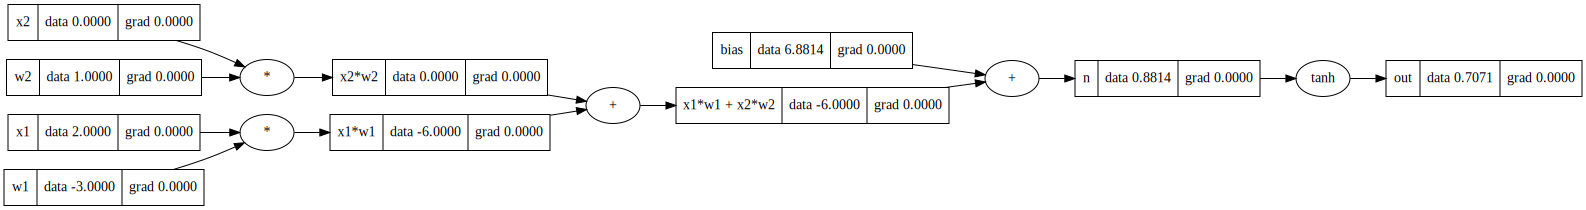

In [26]:
# testing the newer methods with previously known results

# PREVIOUS VALUES

# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
bias = Value(6.8813735870195432, label='bias')

x1w1 = x1*w1
x2w2 = x2*w2

x1w1.label = 'x1*w1'
x2w2.label = 'x2*w2'

# x1w1 + x2w2 + bias
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + bias
n.label = 'n'

out = n.tanh()
out.label = 'out'

draw_graph(out)

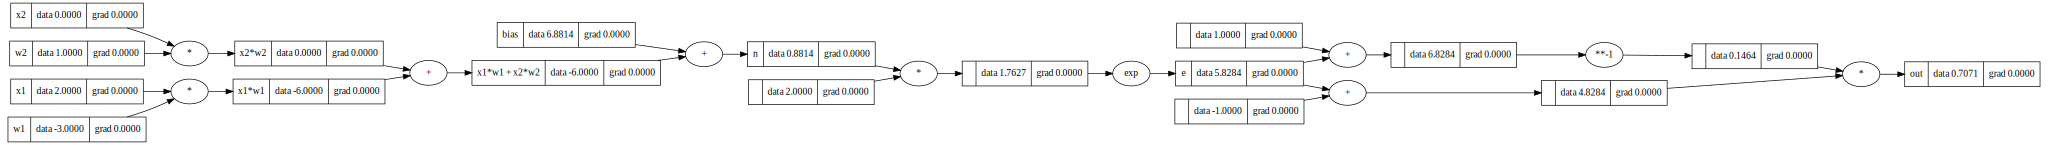

In [27]:
# SAME VALUES & DIFF. OPS

# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
bias = Value(6.8813735870195432, label='bias')

x1w1 = x1*w1
x2w2 = x2*w2

x1w1.label = 'x1*w1'
x2w2.label = 'x2*w2'

# x1w1 + x2w2 + bias
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + bias
n.label = 'n'

e = (2*n).exp()
out = (e - 1) / (e + 1)

out.label = 'out'
e.label = 'e'

draw_graph(out)

In [28]:
# Same thing, but using pytorch
import torch

In [29]:
x1 = torch.Tensor([2.0]).double();                    x1.requires_grad = True;  # here we are assigning a single value to a tensor and then making it a double precision float value, and by default the grad is not applied to the leaf node and so we explicitely set it to true
x2 = torch.Tensor([0.0]).double();                    x2.requires_grad = True;
w1 = torch.Tensor([2.0]).double();                    w1.requires_grad = True;
w2 = torch.Tensor([2.0]).double();                    w2.requires_grad = True;
b = torch.Tensor([6.8813735870195432]).double();      x1.requires_grad = True;

n = x1*w1 + x2*w2 + b
out = torch.tanh(n)

print(out.data.item())          # .item() strips the tensor and returns the single value stored in it
out.backward()

print("<==============>")
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.9999999992927237
<==============>
x2 2.8291053933969226e-09
w2 0.0
x1 2.8291053933969226e-09
w1 2.8291053933969226e-09


In [83]:
class Neuron:
  def __init__(self, nin):                            # the contructor takes in the number of neurons, i.e, how many inputs does this neuron takes
    self.w = [Value(random.uniform(-1,1)) for _ in range (nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    zipped = zip(self.w,x)                            # iterates through all the values in both the lists and returns tuples of values in corresponding indices
    act = sum((wi*xi for wi,xi in zipped), self.b)    # summing all the wi's and xi's then adding bias to it
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]


class Layer:
  def __init__(self, nin, nout):                      # nout -> no. of neurons in each of the layer
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [84]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)
# draw_graph(n(x))

Value(data=-0.42623144312360545)

In [123]:
# current parameters
len(n.parameters()), n.parameters()

(41,
 [Value(data=-0.1597246273128979),
  Value(data=-0.22125453102231638),
  Value(data=0.05918101576478964),
  Value(data=0.020937437595632748),
  Value(data=0.3890214226238092),
  Value(data=-0.8554943984907828),
  Value(data=-0.18153337966585023),
  Value(data=-0.6327828864370006),
  Value(data=-0.7939812619932008),
  Value(data=0.12306912234946808),
  Value(data=0.5631301313017472),
  Value(data=-0.41614772524021415),
  Value(data=-0.13518718937485408),
  Value(data=-0.20524432941592563),
  Value(data=-0.17469663529057813),
  Value(data=-0.14371999966025553),
  Value(data=0.616169382972226),
  Value(data=-0.08030258029244422),
  Value(data=-0.561577291490869),
  Value(data=-0.6274807671870363),
  Value(data=-0.6455327258159925),
  Value(data=-0.205841680916291),
  Value(data=0.8171487513148085),
  Value(data=-0.3695541298785737),
  Value(data=-0.5565051854596833),
  Value(data=0.49868700727963833),
  Value(data=-0.23644405591100728),
  Value(data=0.1875525847347874),
  Value(data=

In [125]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] # desired output

In [182]:
# generated output
# forward pass
ypred = [n(x) for x in xs]
ypred

[Value(data=0.9868888272174385),
 Value(data=-0.9999918033554193),
 Value(data=-0.9980965781935204),
 Value(data=0.9706658552907721)]

In [179]:
# loss calculation
loss = sum((yout - yexp)**2 for yout, yexp in zip(ypred, ys))
loss

Value(data=0.0021674663146977846)

In [180]:
# calculating the gradient of each node w.r.t the loss
# backward pass
loss.backward()

In [135]:
# draw_graph(loss)

In [150]:
# taking one of the parameter's value and gradient to see the changes after tweaking the parameters
print("data: ",n.layers[0].neurons[0].w[0].data, "| grad: ", n.layers[0].neurons[0].w[0].grad)

data:  -0.443108417743277 | grad:  27.53524313332398


In [181]:
# update parameters
for p in n.parameters():
  p.data += -0.01 * p.grad

In [183]:
print("data: ",n.layers[0].neurons[0].w[0].data, "| grad: ", n.layers[0].neurons[0].w[0].grad)

data:  -2.59158618119384 | grad:  26.743847929150174


In [185]:
# repeat ( forward pass -> loss calculation -> backward pass -> update parameters ) until the loss converges
# and this is basically gradient descent

In [223]:
# lets reinitialize the network and add a better (loop) method

# re-initialization
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]

In [226]:
for i in range(100):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout-ypred)**2 for yout, ypred in zip(ypred, ys))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update parameters
  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(i, loss.data)

0 0.009784531151443124
1 0.009547487133495736
2 0.009321093258347348
3 0.009104664022840023
4 0.008897570691634774
5 0.00869923559735607
6 0.008509127108992608
7 0.008326755179419595
8 0.008151667396178454
9 0.007983445470748867
10 0.007821702110857228
11 0.007666078228204424
12 0.007516240440611671
13 0.007371878833188633
14 0.007232704947887505
15 0.00709844997486108
16 0.006968863122505763
17 0.006843710146036387
18 0.006722772016983713
19 0.006605843718198182
20 0.006492733150831894
21 0.006383260141406095
22 0.006277255538486441
23 0.006174560389719171
24 0.006075025191050828
25 0.005978509200888564
26 0.005884879812772308
27 0.005794011980845851
28 0.005705787693038696
29 0.00562009548742225
30 0.005536830007687219
31 0.005455891594117935
32 0.005377185906814633
33 0.005300623578251009
34 0.0052261198925482415
35 0.005153594489110664
36 0.005082971088501011
37 0.005014177238641279
38 0.004947144079610496
39 0.004881806125475849
40 0.0048181010617420125
41 0.004755969557135121
42 

In [227]:
ypred

[Value(data=0.9794354566537836),
 Value(data=-0.9656001909790067),
 Value(data=-0.9852513112534033),
 Value(data=0.9705439873997166)]